# Toy 1d Example for Review Paper

In [1]:
from pathlib import Path
from utils import *

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
out_dir = base_dir / 'out' / 'review_final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:
key = jr.key(325234)

# plot settings
n_grid = 100
n_mc = int(1e5)

# exact inverse problem
noise_sd = 0.1
time_horizon = (-3, 3)
support = (0, 1)
true_param = 0.5
n_time = 8

# surrogate settings
x_design = jnp.array([0.0, 0.4, 0.9]).reshape(-1, 1) # [0.4, 0.8, 0.9]
jitter = 0.0

In [3]:
# Plotting
interval_prob = 0.95
post_ylim = (0.0, 0.15)

gp_colors = {
    "mean":     "#AA3377",
    "interval": "#EEBBDD",
    "points":   "#888888",
    "true":     "#000000"
}

approx_colors = set_plot_theme()

# sns.set_theme(style='ticks', palette='colorblind')
sns.set_context(
    "paper",
    font_scale=3.0,
    rc={"lines.linewidth": 3,
        "axes.linewidth": 1.5}
)

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


## Exact Inverse Problem

In [4]:
# Forward Model
times = jnp.linspace(time_horizon[0], time_horizon[1], n_time)
noise_var = noise_sd ** 2

def forward(u):
    u = jnp.atleast_2d(u)
    xt = jnp.exp(u * times)
    return jnp.mean(xt, axis=1)

In [5]:
# Ground truth
key, key_noise = jr.split(key)

true_observable = forward(true_param)
true_noise = noise_sd * jr.normal(key_noise)
y = true_observable + true_noise

In [6]:
# exact inverse problem 

def log_det_term(u):
    return -0.5 * jnp.log(2*jnp.pi*noise_var)

def log_lik(u):
    return log_det_term(u) - 0.5 * (y - forward(u))**2 / noise_var

class Prior1d(Prior):

    @property
    def dim(self):
        return 1

    @property
    def support(self):
        return support
     
    @property
    def par_names(self):
        return ['u']
    
    def log_density(self, u):
        u = jnp.atleast_2d(u)
        n_inputs = u.shape[0]
        a,b = self.support
        log_dens = -jnp.log(b - a)
        return jnp.tile(log_dens, n_inputs)
    
    def sample(self, key, n: int = 1):
        return jr.uniform(key, shape=(n, self.dim), 
                          minval=self.support[0],
                          maxval=self.support[1])
    
    def sample_lhc(self, key, n: int = 1):
        """Latin hypercube sample"""
        rng_key = _numpy_rng_seed_from_jax_key(key)
        rng = default_rng(seed=rng_key)
        lhc = qmc.LatinHypercube(d=self.dim, rng=rng)

        samp = lhc.random(n=n)
        a,b = self.support
        return jnp.asarray(a + samp * (b - a))
    
prior = Prior1d()
posterior = Posterior(prior, log_lik)

In [7]:
grid = Grid(low=support[0], high=support[1], 
            n_points_per_dim=n_grid, 
            dim_names=prior.par_names)

## Forward Model Surrogate

In [9]:
# construct design
forward_design = gpx.Dataset(X=x_design,
                             y=forward(x_design).reshape(-1, 1))

# fit GP surrogate
forward_gp, _ = construct_gp(forward_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(forward_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
forward_gp.prior.kernel.variance.set_value(sd_new ** 2)

forward_surrogate = wrap_gp(forward_gp, forward_design, jitter)

# Induced posterior surrogate
fwd_post_surr = FwdModelGaussianSurrogateGrid(gp=forward_surrogate,
                                              log_prior=posterior.prior.log_density,
                                              y=y.reshape(1,1),
                                              noise_cov_tril=jnp.array(noise_sd).reshape(1, 1),
                                              support=posterior.support)

key, key_samp = jr.split(key)
post_em_fwd = SurrogatePost1d(post_em=fwd_post_surr,
                              post_true=posterior,
                              filename_label='fwdem',
                              target_label=r'$G(u)$',
                              f_target=forward,
                              grid=grid,
                              key=key_samp,
                              n_mc=n_mc,
                              plot_surrogate_fn=plot_gp_surrogate,
                              plot_log_dens_surrogate_fn=plot_log_dens_surrogate_fwd,
                              plot_dens_surrogate_fn=plot_dens_surrogate_fwd)

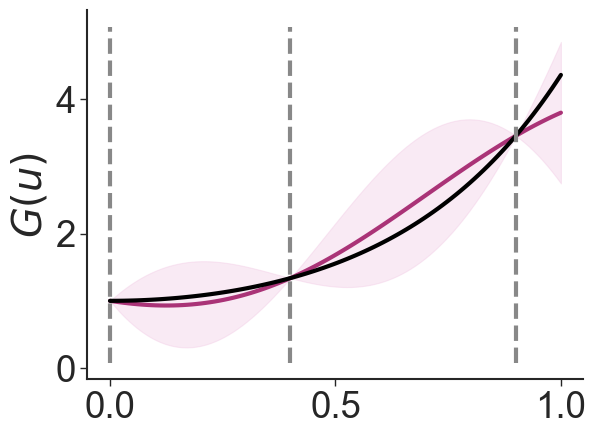

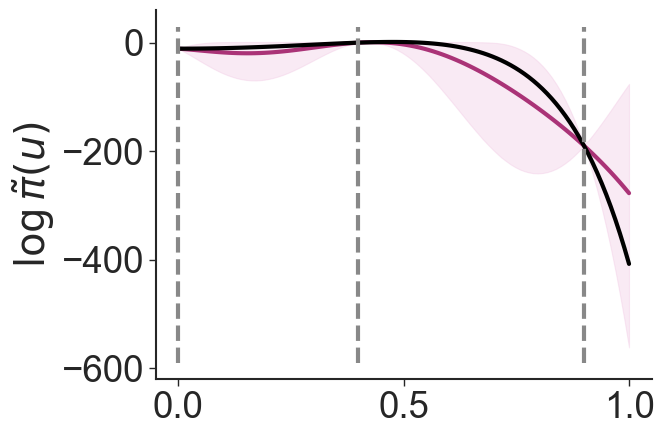

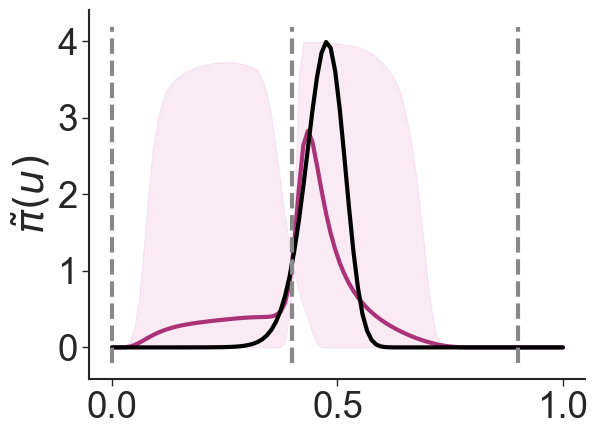

In [10]:
fig, ax = post_em_fwd.plot_surrogate(gp_colors=gp_colors)
fig, ax = post_em_fwd.plot_log_dens_surrogate(gp_colors=gp_colors)
fig, ax = post_em_fwd.plot_dens_surrogate(gp_colors=gp_colors)

In [ ]:
key, key_fwd_plots = jr.split(key)

save_fwd_em_plots(key=key_fwd_plots,
                  grid=grid, 
                  f_target=forward, 
                  post_em=fwd_post_surr,
                  post_true=posterior,
                  out_dir=out_dir,
                  gp_colors=gp_colors,
                  post_colors=approx_colors,
                  interval_prob=interval_prob)

## Log-Density Surrogate

In [ ]:
# same design inputs as forward model surrogate
ldens_design = gpx.Dataset(X=forward_design.X,
                           y=posterior.log_density(forward_design.X).reshape(-1, 1))

# fit GP surrogate
ldens_gp, _ = construct_gp(ldens_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(ldens_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
ldens_gp.prior.kernel.variance.set_value(sd_new ** 2)

ldens_surrogate = wrap_gp(ldens_gp, ldens_design, jitter)

# Induced posterior surrogate    
ldens_post_surr = LogDensGPSurrogateGrid(log_dens=ldens_surrogate, support=posterior.support)

In [ ]:
key, key_ldens_plots = jr.split(key)

save_ldens_em_plots(key=key_ldens_plots, 
                    grid=grid, 
                    f_target=posterior.log_density, 
                    post_em=ldens_post_surr, 
                    post_true=posterior, 
                    out_dir=out_dir, 
                    gp_colors=gp_colors, 
                    post_colors=approx_colors,
                    interval_prob=interval_prob,
                    post_ylim=post_ylim)

## Clipped Log Density Surrogate

In [ ]:
def upper_bound(u):
    return log_det_term(u) + prior.log_density(u)

clip_post_surr = LogDensClippedGPSurrogateGrid(log_dens=ldens_surrogate,
                                               log_dens_upper_bound=upper_bound,
                                               support=posterior.support)

In [ ]:
key, key_clip_plots = jr.split(key)

save_clipped_ldens_em_plots(key=key_clip_plots, 
                            grid=grid, 
                            f_target=posterior.log_density, 
                            post_em=clip_post_surr, 
                            post_true=posterior, 
                            out_dir=out_dir, 
                            gp_colors=gp_colors, 
                            post_colors=colors,
                            interval_prob=interval_prob)